# Informed Search Strategies: Greedy Best-First and A* Heuristic (Manhattan Distance)

### Author
- Name: Ainun Nadhifah Syamsiyah
- NRP: 5025221053

## Problem Statement

Terdapat kasus 8-puzzles dengan informasi state awal dan goal sebagai [berikut](https://hackmd.io/_uploads/SJQIYsvga.png)

Selesaikan kasus 8-puzzles diatas menggunakan 2 metode informed
search dengan actual cost adalah satu setiap aksi dan fungsi heuristik
adalah Manhattan distance (jumlah jarak masing-masing kotak ke
tujuan) atau Jumlah kotak salah tempat

## Solution

Demi kemudahan dalam menemukan solusi dari kasus 8-puzzles, kita akan membuat function untuk menggambarkan setiap state pada 8-puzzle

In [30]:
import math
import matplotlib.pyplot as plt

class NPuzzleState:
    
    def __init__(self, N=8, tiles=None):
        if tiles is None:
            self.tiles = tuple(range(N + 1))
        else:
            N = len(tiles) - 1
            self.tiles = tuple(tiles[:])
        
        self.N = N
        self.grid_size = int(math.sqrt(N + 1))
            
    def successors(self):
        blank_idx = self.tiles.index(0)
        successors = []
        
        # left
        if blank_idx % self.grid_size > 0:
            tiles = list(self.tiles)
            tiles[blank_idx], tiles[blank_idx - 1] = tiles[blank_idx - 1], tiles[blank_idx]
            successor = NPuzzleState(tiles=tiles)
            successors.append((successor, 'Left', 1))
        
        # up
        if blank_idx >= self.grid_size:
            tiles = list(self.tiles)
            tiles[blank_idx], tiles[blank_idx - self.grid_size] = tiles[blank_idx - self.grid_size], tiles[blank_idx]
            successor = NPuzzleState(tiles=tiles)
            successors.append((successor, 'Up', 1))
        
        # right
        if blank_idx % self.grid_size < self.grid_size - 1:
            tiles = list(self.tiles)
            tiles[blank_idx], tiles[blank_idx + 1] = tiles[blank_idx + 1], tiles[blank_idx]
            successor = NPuzzleState(tiles=tiles)
            successors.append((successor, 'Right', 1))
            
        # down
        if blank_idx + self.grid_size < len(self.tiles):
            tiles = list(self.tiles)
            tiles[blank_idx], tiles[blank_idx + self.grid_size] = tiles[blank_idx + self.grid_size], tiles[blank_idx]
            successor = NPuzzleState(tiles=tiles)
            successors.append((successor, 'Down', 1))
        
        return successors
    
    def is_goal(self, goal_state):
        return self == goal_state
    
    def plot(self, ax=None, title=None, fs=20):
        if ax is None:
            _, ax = plt.subplots(1)
            
        gs = self.grid_size
        
        border = plt.Rectangle((0, 0), gs, gs, ec='k', fc='w', lw=3)
        ax.add_patch(border)
        
        for i, tile in enumerate(self.tiles):
            if tile == 0: continue
            col = self.grid_size - 1 - i // self.grid_size
            row = i %  self.grid_size
            cell = plt.Rectangle((row, col), 1, 1, fc='darkslateblue', ec='k', lw=3, alpha=0.4)
            ax.add_patch(cell)
            tileSq = plt.Rectangle((row + 0.15, col + 0.15), 0.7, 0.7, fc='darkslateblue', ec='k', lw=1, alpha=0.8)
            ax.add_patch(tileSq)
            ax.text(row + 0.5, col + 0.5, f"{tile}", color='w', fontsize=fs, va='center', ha='center')
        
        ax.axis('square')
        ax.axis('off')
        if title:
            ax.set_title(title, fontsize=fs)
            
    def __hash__(self):
        return hash(self.tiles)
    
    def __eq__(self, other):
        if self is other: return True
        if other is None: return False
        if not isinstance(other, NPuzzleState): return False
        
        return self.tiles == other.tiles
    
    def __str__(self):
        """ An string representation of the tiles configuration in 2d format.
        """
        result = ''
        for i in range(len(self.tiles)):
            result += f' {self.tiles[i]:2d} ' if self.tiles[i] != 0 else '    '
            if i % self.grid_size == self.grid_size - 1 and i < self.N:
                result += '\n'
        return result
    
    def __repr__(self):
        return f'NPuzzleState(N={self.N}, tiles={self.tiles})'

Selanjutnya kita akan mendeklarasikan start state dan goal state pada puzzle tersebut

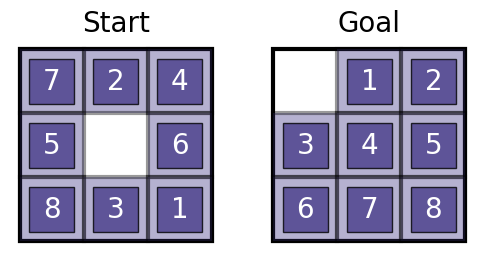

In [31]:
start_state_tiles = [
    7, 2, 4, 
    5, 0, 6, 
    8, 3, 1]

goal_state_tiles = [
    0, 1, 2, 
    3, 4, 5,
    6, 7, 8]

start_state = NPuzzleState(tiles=start_state_tiles)
goal_state = NPuzzleState(tiles=goal_state_tiles)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
start_state.plot(axes[0], 'Start')
goal_state.plot(axes[1], 'Goal')
plt.show()

Kemudian kita akan membuat helper function untuk mencetak dan menampilkan setiap solusi yang ditemukan

In [32]:
def print_solution(start_state, path):
    if not isinstance(path, list):
        print("No solution found!")
        return
    
    print(start_state)
    for state, action in path:
        print("\n {} \n".format(action))
        print(state)


def show_solution(start_state, path, ncols=5, fs=18):
    if not isinstance(path, list):
        print("No solution found!")
        return
    
    N = len(path) + 1
    nrows = int(math.ceil(N / ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3 * nrows))
    
    if nrows > 1:
        start_state.plot(axes[0][0], 'start', fs)
        for i, (state, action) in enumerate(path):
            state.plot(axes[(i + 1) // ncols][(i + 1) % ncols], action, fs)
        for i in range(N, nrows * ncols):
            axes[nrows-1][i % ncols].axis('off')
    
    else:
        start_state.plot(axes[0], 'start', fs)
        for i, (state, action) in enumerate(path):
            state.plot(axes[i + 1], action, fs)
        for i in range(N, ncols):
            axes[i].axis('off')


def solution(node):
    path = []
    while node.parent is not None:
        path = [(node.state, node.action)] + path
        node = node.parent
    return path

Perhitungan heuristic kali ini menggunakan Manhattan Distance. Oleh karena itu, kita akan mendeklarasikan fungsi untuk menghitung Manhattan Distance

In [33]:
def manhatan_distance(tile, state1, state2):
    i = state1.tiles.index(tile)
    j = state2.tiles.index(tile)
    
    gs = state1.grid_size
    
    row_i, col_i = i // gs, i % gs
    row_j, col_j = j // gs, j % gs
    
    return abs(row_i - row_j) + abs(col_i - col_j)

Kemudian kita deklarasikan fungsi heuristic dengan manhattan distance

In [34]:
def heuristic(state, goal):
    return sum([manhatan_distance(tile, state, goal) for tile in range(1, state.N + 1)])

### Greedy Best-First Search

Greedy Best-First Search akan mengekspand node yang mendekati goal dengan menghitung fungsi heuristik. Secara matematis, dapat ditulis:
$$f(n) = h(n)$$
dengan $h(n)$ adalah fungsi heuristik. Pseudocode dari Greedy Best-First Search adalah sebagai berikut:
- `frontier` pada priority queue adalah node yang belum diekspansi dengan jarak dari goal state merupakan prioritas antriannya
- kemudian untuk node yang paling dekat dengan goal state akan dipilih pada setiap iterasi

kita perlu mengimplementasi sebuah priority queue. Implementasinya adalah sebagai berikut:

In [35]:
import heapq

class PriorityQueue:
    def __init__(self, items=None):
        self._items = []
        self.index = 0
        
        if items:
            for item, priority in items:
                self.push(item, priority)
        
    def push(self, item, priority):
        entry = (priority, self.index, item)
        heapq.heappush(self._items, entry)
        self.index += 1
    
    def pop(self):
        try:
            _, _, item = heapq.heappop(self._items)
            return item
        except:
            print('ERROR! trying to pop an element from an empty priority queue.')
    
    def is_empty(self):
        return len(self._items) == 0
    
    def __repr__(self):
        return f'PriorityQueue(items={self._items})'
    
    def __str__(self):
        res = '['
        for priority, _, item in self._items:
            res += f' {item}({priority}) '
        res += ']'
        return res

Setelah itu, kita dapat mengimplementasi seluruh pseudocode dari greedy best-first search

In [36]:
from collections import namedtuple

Node = namedtuple('Node', 'state parent action cost')

def greedy_search(start_state, goal_state):
    
    num_generated = 0
    frontier = PriorityQueue()
    reached = dict()  # a dictionary of (state, node)

    node = Node(start_state, None, None, 0) 
    frontier.push(node, heuristic(start_state, goal_state))
    reached[start_state] = node

    while not frontier.is_empty():
        # select a node
        node = frontier.pop()
        
        # goal test
        if node.state == goal_state:
            return solution(node), num_generated
        
        # expand
        for successor, action, step_cost in node.state.successors():
            num_generated += 1
            path_cost = node.cost + step_cost
            
            if successor not in reached or path_cost < reached[successor].cost:
                child_node = Node(successor, node, action, path_cost)
                reached[successor] = child_node
                frontier.push(child_node, heuristic(successor, goal_state))
        
    return None, num_generated  # no solution found

Kembali ke soal, maka solusi dari 8 puzzle tersebut dengan greedy best-first search adalah

Number of generated nodes: 1408


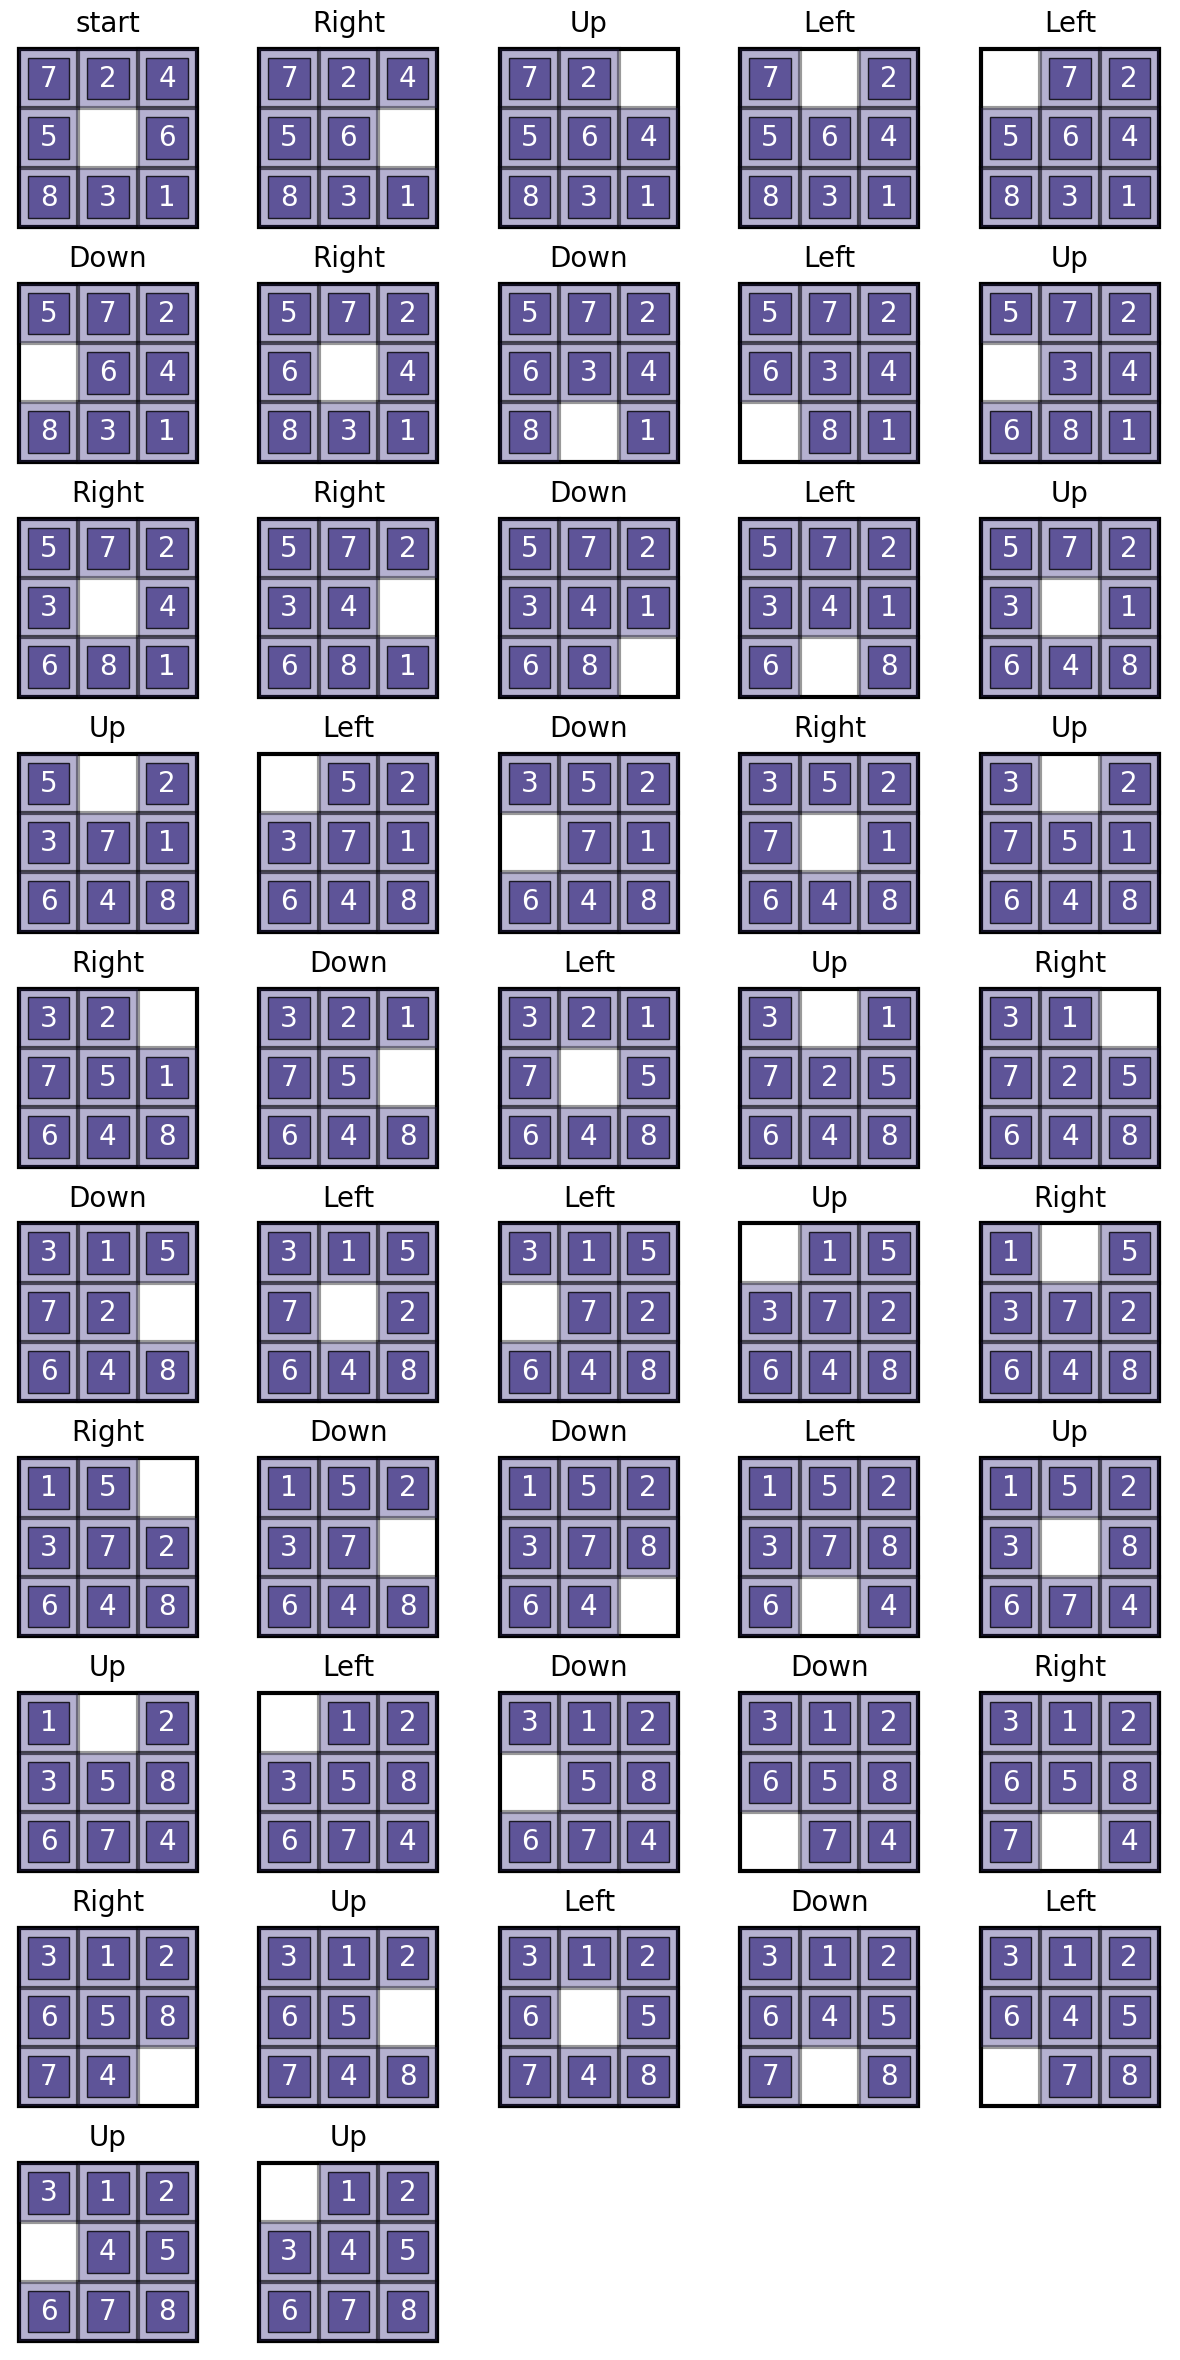

In [37]:
path, num_generated = greedy_search(start_state, goal_state)
print(f'Number of generated nodes: {num_generated}')
show_solution(start_state, path, ncols=5, fs=20)

Sehingga didapat banyak langkah minimum pada 8 puzzle tersebut agar dapat mencapai goal state dengan menggunakan greedy best-first search adalah **47 langkah**. 

### A* Search

A* search merupakan kombinasi antara Uniform Cost Search dan Greedy Search guna menghindari ekspansi pada path yang memerlukan biaya besar.

Fungsi untuk menghitung A* adalah sebagai berikut:
$$f(n)=g(n)+h(n)$$
dengan $g(n)$ menyatakan cost untuk mencapai state $n$ dan $h(n)$ merupakan fungsi heuristik untuk mencapai state $n$.

Pseudocode A* sendiri serupa dengan greedy best-first search. Akan tetapi, A* akan memilih node yang belum diekspansi dengan cost $f(n)$ minimum pada setiap iterasinya.

Algoritma dari A* search adalah sebagai berikut:

In [38]:
def a_star_search(start_state, goal_state):
    
    num_generated = 0
    frontier = PriorityQueue()
    reached = dict()  # a dictionary of (state, node)

    node = Node(start_state, None, None, 0) 
    frontier.push(node, 0 + heuristic(start_state, goal_state))
    reached[start_state] = node

    while not frontier.is_empty():
        # select a node
        node = frontier.pop()
        
        # goal test
        if node.state == goal_state:
            return solution(node), num_generated
        
        # expand
        for successor, action, step_cost in node.state.successors():
            num_generated += 1
            path_cost = node.cost + step_cost
            
            if successor not in reached or path_cost < reached[successor].cost:
                child_node = Node(successor, node, action, path_cost)
                reached[successor] = child_node
                frontier.push(child_node, path_cost + heuristic(successor, goal_state))
        
    return None, num_generated  # no solution found

Kembali ke soal, maka solusi dari 8 puzzle tersebut dengan A* search adalah

Number of generated nodes: 10644


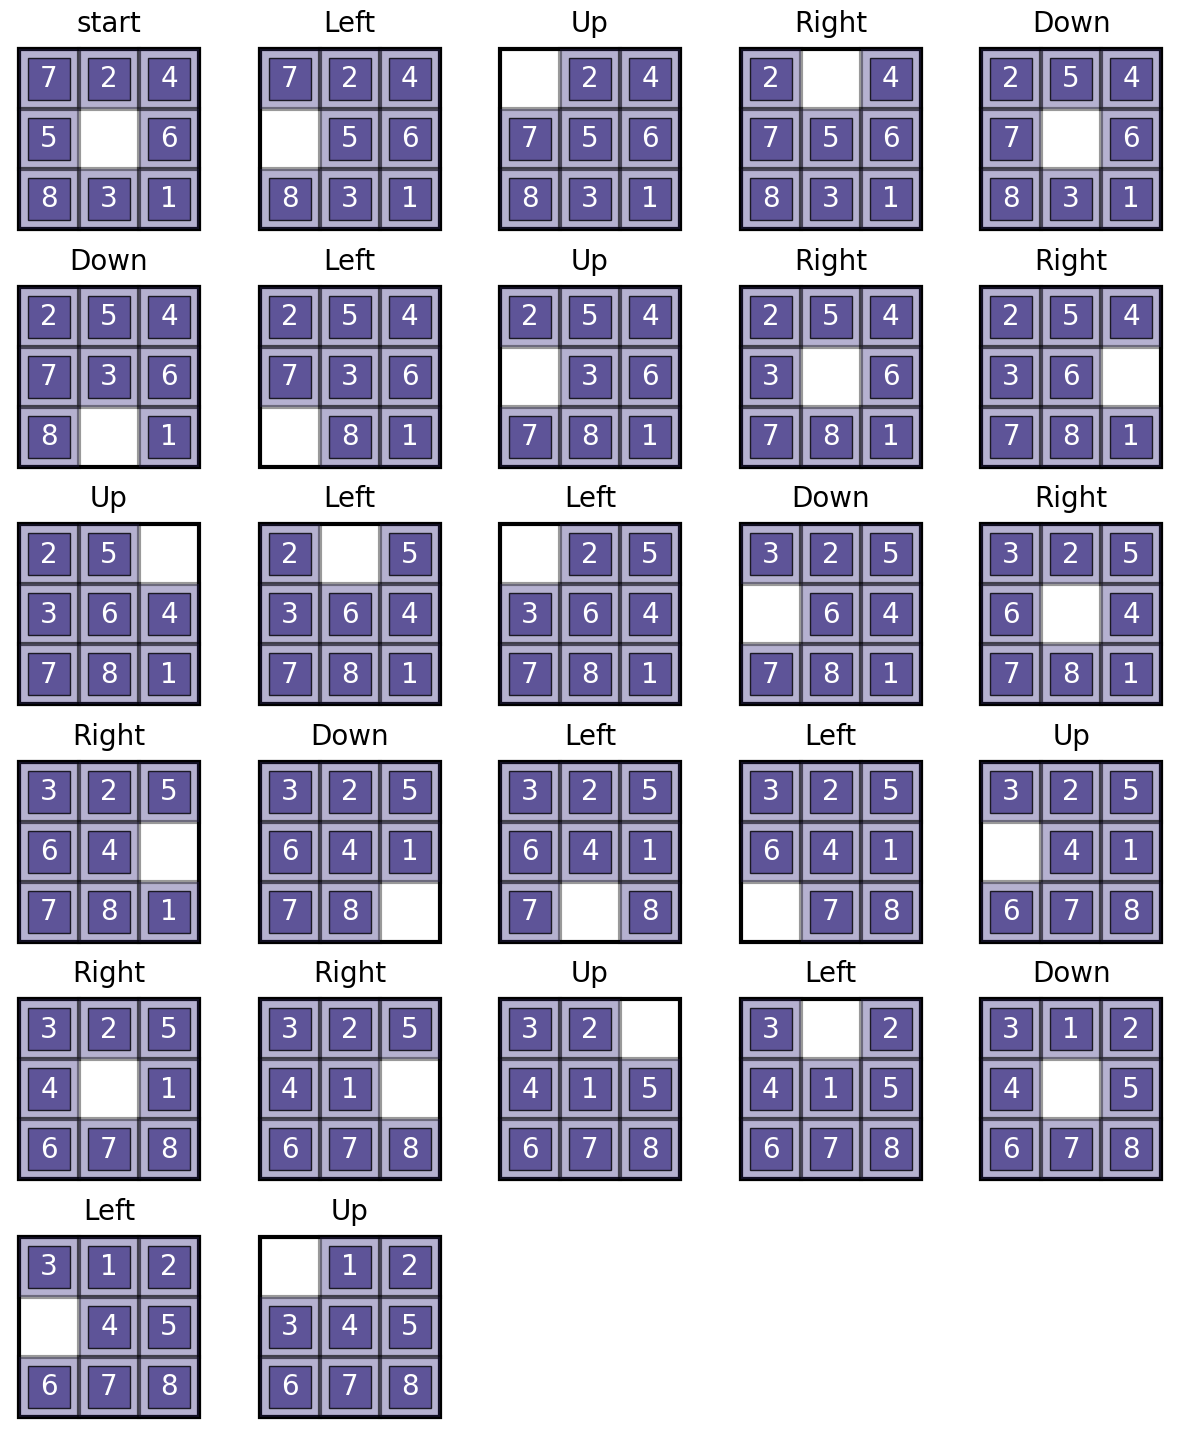

In [39]:
path, num_generated = a_star_search(start_state, goal_state)
print(f'Number of generated nodes: {num_generated}')
show_solution(start_state, path, ncols=5, fs=20)

Sehingga didapat banyak langkah minimum pada 8 puzzle tersebut agar dapat mencapai goal state dengan menggunakan A* search adalah **27 langkah**. 